<a href="https://colab.research.google.com/github/raagzz/capstone-project/blob/main/Tab_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
##Installing the required packages
!pip install modal-python
!pip install openml

In [8]:
##Importing Packages
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import make_classification

import openml

from modAL.models import ActiveLearner, Committee
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling
from modAL.disagreement import vote_entropy_sampling

## Generating Data

In [9]:
X, y = make_classification(n_samples=5000, n_features=20, n_informative=15, n_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
### Initial Data For Tarining
initial_idx = np.random.choice(range(len(X_train)), size=100, replace=False)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

In [11]:
### Pool Data - Unlabeled
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

## Random Sampling - Baseline

In [12]:
def random_sampling(learner, X_pool, n_samples=1):
    ''' Randomly selects n_samples from X_pool '''
    n_pool = len(X_pool)
    query_idx = np.random.choice(range(n_pool), size=n_samples, replace=False)
    return query_idx, X_pool[query_idx]

In [13]:
learner_random = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=random_sampling,
    X_training=X_initial, y_training=y_initial
)

##Uncertainty Sampling

In [14]:
learner_uncertainty = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
)

## Entropy Sampling

In [15]:
learner_entropy = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=entropy_sampling,
    X_training=X_initial, y_training=y_initial
)

## Margin Sampling

In [16]:
learner_margin = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=margin_sampling,
    X_training=X_initial, y_training=y_initial
)

## Query by Committee

In [17]:
##numbers of members in the committe
n_members = 5
##Models
committee_estimators = [RandomForestClassifier() for _ in range(n_members)]
learner_committee = Committee(
    learner_list=[
        ActiveLearner(
            estimator=estimator,
            X_training=X_initial,
            y_training=y_initial
        ) for estimator in committee_estimators
    ],
    query_strategy=vote_entropy_sampling  ##Vote entropy sampling for disagreement-based querying
)

### Active Learning Parameters
- Number of queries (```n_queries = 50```)
- Accuracy
- F1 Score

In [18]:
### Helper Variables
n_queries = 50
performance_baseline = []
performance_entropy = []
performance_uncertainty = []
performance_committee = []
performance_margin = []

## Active Learning Loop

In [19]:
def run_active_learning(learner, X_pool, y_pool, strategy_name):
    '''Keeps the loop running and capture the performance of the model'''
    performance = []
    for i in range(n_queries):
        query_idx, _ = learner.query(X_pool)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
        y_pred = learner.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        performance.append((acc, f1))
        print(f"{strategy_name} | Query {i+1}: Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")
    return performance

### Run active learning and store performance

In [20]:
performance_baseline = run_active_learning(learner_random, X_pool.copy(), y_pool.copy(), "Random Sampling")

Random Sampling | Query 1: Accuracy = 0.7100, F1-Score = 0.7478
Random Sampling | Query 2: Accuracy = 0.7153, F1-Score = 0.7547
Random Sampling | Query 3: Accuracy = 0.7120, F1-Score = 0.7471
Random Sampling | Query 4: Accuracy = 0.7147, F1-Score = 0.7512
Random Sampling | Query 5: Accuracy = 0.7333, F1-Score = 0.7619
Random Sampling | Query 6: Accuracy = 0.7160, F1-Score = 0.7485
Random Sampling | Query 7: Accuracy = 0.7213, F1-Score = 0.7527
Random Sampling | Query 8: Accuracy = 0.7227, F1-Score = 0.7512
Random Sampling | Query 9: Accuracy = 0.7153, F1-Score = 0.7466
Random Sampling | Query 10: Accuracy = 0.7193, F1-Score = 0.7453
Random Sampling | Query 11: Accuracy = 0.7167, F1-Score = 0.7487
Random Sampling | Query 12: Accuracy = 0.7340, F1-Score = 0.7586
Random Sampling | Query 13: Accuracy = 0.7280, F1-Score = 0.7515
Random Sampling | Query 14: Accuracy = 0.7113, F1-Score = 0.7393
Random Sampling | Query 15: Accuracy = 0.7233, F1-Score = 0.7486
Random Sampling | Query 16: Accura

In [21]:
performance_uncertainty = run_active_learning(learner_uncertainty, X_pool.copy(), y_pool.copy(), "Uncertainty Sampling")

Uncertainty Sampling | Query 1: Accuracy = 0.7033, F1-Score = 0.7368
Uncertainty Sampling | Query 2: Accuracy = 0.7127, F1-Score = 0.7519
Uncertainty Sampling | Query 3: Accuracy = 0.7007, F1-Score = 0.7421
Uncertainty Sampling | Query 4: Accuracy = 0.7233, F1-Score = 0.7575
Uncertainty Sampling | Query 5: Accuracy = 0.7107, F1-Score = 0.7497
Uncertainty Sampling | Query 6: Accuracy = 0.7173, F1-Score = 0.7552
Uncertainty Sampling | Query 7: Accuracy = 0.7160, F1-Score = 0.7491
Uncertainty Sampling | Query 8: Accuracy = 0.7227, F1-Score = 0.7488
Uncertainty Sampling | Query 9: Accuracy = 0.7173, F1-Score = 0.7485
Uncertainty Sampling | Query 10: Accuracy = 0.7387, F1-Score = 0.7667
Uncertainty Sampling | Query 11: Accuracy = 0.7373, F1-Score = 0.7592
Uncertainty Sampling | Query 12: Accuracy = 0.7427, F1-Score = 0.7638
Uncertainty Sampling | Query 13: Accuracy = 0.7387, F1-Score = 0.7541
Uncertainty Sampling | Query 14: Accuracy = 0.7540, F1-Score = 0.7709
Uncertainty Sampling | Query 

In [22]:
performance_entropy = run_active_learning(learner_entropy, X_pool.copy(), y_pool.copy(), "Entropy Sampling")

Entropy Sampling | Query 1: Accuracy = 0.7133, F1-Score = 0.7488
Entropy Sampling | Query 2: Accuracy = 0.7113, F1-Score = 0.7510
Entropy Sampling | Query 3: Accuracy = 0.6980, F1-Score = 0.7318
Entropy Sampling | Query 4: Accuracy = 0.7207, F1-Score = 0.7504
Entropy Sampling | Query 5: Accuracy = 0.7047, F1-Score = 0.7383
Entropy Sampling | Query 6: Accuracy = 0.7253, F1-Score = 0.7479
Entropy Sampling | Query 7: Accuracy = 0.7307, F1-Score = 0.7534
Entropy Sampling | Query 8: Accuracy = 0.7220, F1-Score = 0.7474
Entropy Sampling | Query 9: Accuracy = 0.7320, F1-Score = 0.7590
Entropy Sampling | Query 10: Accuracy = 0.7360, F1-Score = 0.7594
Entropy Sampling | Query 11: Accuracy = 0.7307, F1-Score = 0.7491
Entropy Sampling | Query 12: Accuracy = 0.7567, F1-Score = 0.7656
Entropy Sampling | Query 13: Accuracy = 0.7427, F1-Score = 0.7560
Entropy Sampling | Query 14: Accuracy = 0.7340, F1-Score = 0.7483
Entropy Sampling | Query 15: Accuracy = 0.7407, F1-Score = 0.7472
Entropy Sampling | 

In [23]:
performance_committee = run_active_learning(learner_committee, X_pool.copy(), y_pool.copy(), "Query by Committee")

Query by Committee | Query 1: Accuracy = 0.7153, F1-Score = 0.7530
Query by Committee | Query 2: Accuracy = 0.7173, F1-Score = 0.7491
Query by Committee | Query 3: Accuracy = 0.7133, F1-Score = 0.7471
Query by Committee | Query 4: Accuracy = 0.7127, F1-Score = 0.7439
Query by Committee | Query 5: Accuracy = 0.7167, F1-Score = 0.7463
Query by Committee | Query 6: Accuracy = 0.7113, F1-Score = 0.7415
Query by Committee | Query 7: Accuracy = 0.7200, F1-Score = 0.7494
Query by Committee | Query 8: Accuracy = 0.7220, F1-Score = 0.7453
Query by Committee | Query 9: Accuracy = 0.7260, F1-Score = 0.7439
Query by Committee | Query 10: Accuracy = 0.7413, F1-Score = 0.7581
Query by Committee | Query 11: Accuracy = 0.7367, F1-Score = 0.7536
Query by Committee | Query 12: Accuracy = 0.7320, F1-Score = 0.7439
Query by Committee | Query 13: Accuracy = 0.7360, F1-Score = 0.7522
Query by Committee | Query 14: Accuracy = 0.7373, F1-Score = 0.7525
Query by Committee | Query 15: Accuracy = 0.7333, F1-Scor

In [24]:
performance_margin = run_active_learning(learner_margin, X_pool.copy(), y_pool.copy(), "Margin Sampling")

Margin Sampling | Query 1: Accuracy = 0.7093, F1-Score = 0.7402
Margin Sampling | Query 2: Accuracy = 0.7120, F1-Score = 0.7483
Margin Sampling | Query 3: Accuracy = 0.7087, F1-Score = 0.7388
Margin Sampling | Query 4: Accuracy = 0.7247, F1-Score = 0.7531
Margin Sampling | Query 5: Accuracy = 0.7107, F1-Score = 0.7465
Margin Sampling | Query 6: Accuracy = 0.7027, F1-Score = 0.7419
Margin Sampling | Query 7: Accuracy = 0.7060, F1-Score = 0.7417
Margin Sampling | Query 8: Accuracy = 0.7113, F1-Score = 0.7445
Margin Sampling | Query 9: Accuracy = 0.7260, F1-Score = 0.7598
Margin Sampling | Query 10: Accuracy = 0.7067, F1-Score = 0.7460
Margin Sampling | Query 11: Accuracy = 0.7167, F1-Score = 0.7457
Margin Sampling | Query 12: Accuracy = 0.7207, F1-Score = 0.7483
Margin Sampling | Query 13: Accuracy = 0.7200, F1-Score = 0.7500
Margin Sampling | Query 14: Accuracy = 0.7253, F1-Score = 0.7527
Margin Sampling | Query 15: Accuracy = 0.7467, F1-Score = 0.7640
Margin Sampling | Query 16: Accura

## Helper Steps For Plotting

In [25]:
acc_baseline, f1_baseline = zip(*performance_baseline)
acc_uncertainty, f1_uncertainty = zip(*performance_uncertainty)
acc_entropy, f1_entropy = zip(*performance_entropy)
acc_committee, f1_committee = zip(*performance_committee)
acc_margin, f1_margin = zip(*performance_margin)

In [28]:
import matplotlib.pyplot as plt

## Plotting the Performance over the queries

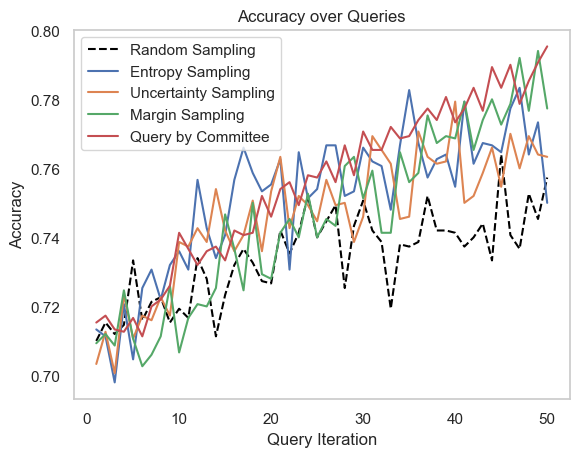

In [57]:
plt.plot(range(1, n_queries + 1), acc_baseline, label='Random Sampling', color='black', linestyle='--')
plt.plot(range(1, n_queries + 1), acc_entropy, label='Entropy Sampling')
plt.plot(range(1, n_queries + 1), acc_uncertainty, label='Uncertainty Sampling')
plt.plot(range(1, n_queries + 1), acc_margin, label='Margin Sampling')
plt.plot(range(1, n_queries + 1), acc_committee, label='Query by Committee')

plt.title("Accuracy over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("Accuracy")
plt.grid(False)
plt.legend()

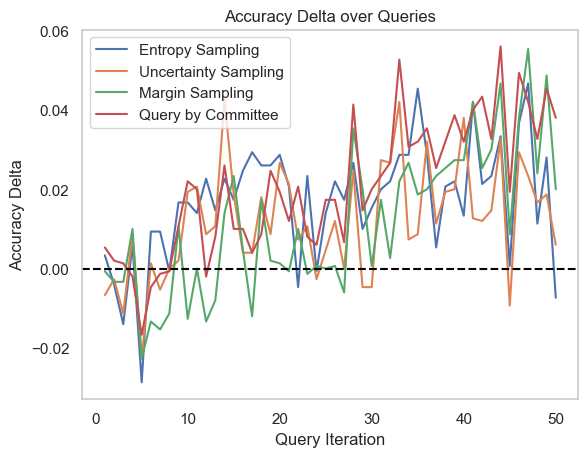

In [49]:
plt.plot(range(1, n_queries + 1), np.array(acc_entropy) - np.array(acc_baseline), label='Entropy Sampling')
plt.plot(range(1, n_queries + 1), np.array(acc_uncertainty) - np.array(acc_baseline), label='Uncertainty Sampling')
plt.plot(range(1, n_queries + 1), np.array(acc_margin) - np.array(acc_baseline), label='Margin Sampling')
plt.plot(range(1, n_queries + 1), np.array(acc_committee) - np.array(acc_baseline), label='Query by Committee')
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Accuracy Delta over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("Accuracy Delta")
plt.grid(False)
plt.legend()

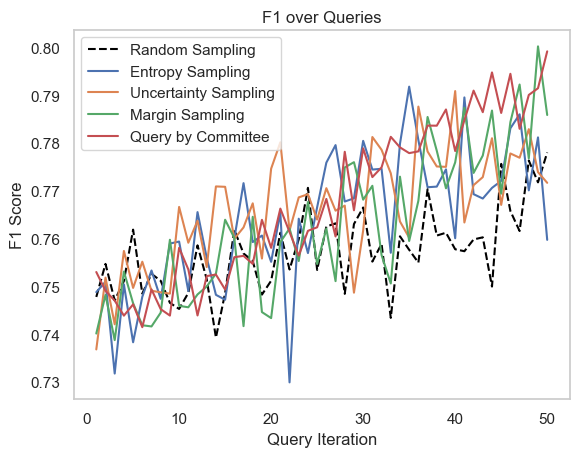

In [50]:
plt.plot(range(1, n_queries + 1), f1_baseline, label='Random Sampling', color='black', linestyle='--')
plt.plot(range(1, n_queries + 1), f1_entropy, label='Entropy Sampling')
plt.plot(range(1, n_queries + 1), f1_uncertainty, label='Uncertainty Sampling')
plt.plot(range(1, n_queries + 1), f1_margin, label='Margin Sampling')
plt.plot(range(1, n_queries + 1), f1_committee, label='Query by Committee')

plt.title("F1 over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("F1 Score")
plt.grid(False)
plt.legend()

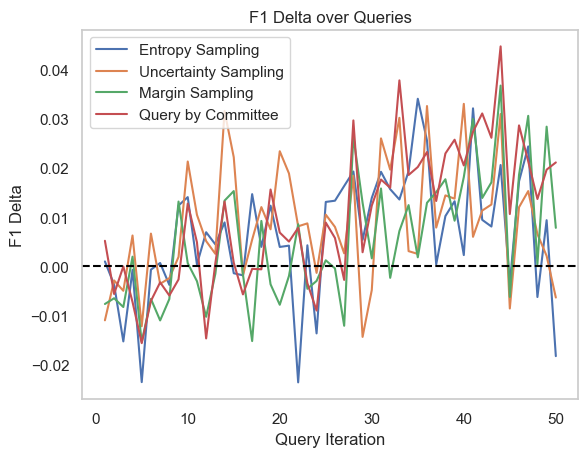

In [51]:
plt.plot(range(1, n_queries + 1), np.array(f1_entropy) - np.array(f1_baseline), label='Entropy Sampling')
plt.plot(range(1, n_queries + 1), np.array(f1_uncertainty) - np.array(f1_baseline), label='Uncertainty Sampling')
plt.plot(range(1, n_queries + 1), np.array(f1_margin) - np.array(f1_baseline), label='Margin Sampling')
plt.plot(range(1, n_queries + 1), np.array(f1_committee) - np.array(f1_baseline), label='Query by Committee')

plt.axhline(y=0, color='black', linestyle='--')
plt.title("F1 Delta over Queries")
plt.xlabel("Query Iteration")
plt.ylabel("F1 Delta")
plt.grid(False)
plt.legend()